In [16]:
import torch
import os
import monai

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

join = os.path.join

In [19]:
from skimage import io

ts_img_path = 'dataset/StowSam/raw_input/test2/images'
ts_gt_path = 'dataset/StowSam/raw_input/test2/masks'

In [22]:

import h5py
from tqdm import trange


h5_file_path = "dataset/bin_syn/test_shard_000000"
img_format = 'png'
os.makedirs(ts_img_path, exist_ok=True)
os.makedirs(ts_gt_path, exist_ok=True)

# TODO: MODIFY FOR SPECIFIC H5 FILE CONTENT
with h5py.File(f"{h5_file_path}.h5", 'r') as h5_file:
    print(f"{h5_file['data'][0]}")
    for id in trange(100):
        io.imsave(f"{ts_img_path}/scene{id+1}_frame0.{img_format}", h5_file['data'][id][0])
        io.imsave(f"{ts_img_path}/scene{id+1}_frame1.{img_format}", h5_file['data'][id][1])
        io.imsave(f"{ts_gt_path}/scene{id+1}_frame0.{img_format}", h5_file['mask'][id][0])
        io.imsave(f"{ts_gt_path}/scene{id+1}_frame1.{img_format}", h5_file['mask'][id][1])

[[[[188 204 221 255]
   [188 204 221 255]
   [188 204 221 255]
   ...
   [188 204 221 255]
   [188 204 221 255]
   [188 204 221 255]]

  [[187 203 221 255]
   [187 203 221 255]
   [187 203 221 255]
   ...
   [187 203 221 255]
   [187 203 221 255]
   [187 203 221 255]]

  [[187 203 221 255]
   [187 203 221 255]
   [187 203 221 255]
   ...
   [187 203 221 255]
   [187 203 221 255]
   [187 203 221 255]]

  ...

  [[161 178 200 255]
   [161 178 200 255]
   [161 178 200 255]
   ...
   [161 178 200 255]
   [161 178 200 255]
   [161 178 200 255]]

  [[161 178 200 255]
   [161 178 200 255]
   [161 178 200 255]
   ...
   [161 178 200 255]
   [161 178 200 255]
   [161 178 200 255]]

  [[161 178 200 255]
   [161 178 200 255]
   [161 178 200 255]
   ...
   [161 178 200 255]
   [161 178 200 255]
   [161 178 200 255]]]


 [[[188 204 221 255]
   [188 204 221 255]
   [188 204 221 255]
   ...
   [188 204 221 255]
   [188 204 221 255]
   [188 204 221 255]]

  [[187 203 221 255]
   [187 203 221 255]
   [

100%|██████████| 100/100 [00:04<00:00, 22.10it/s]


In [23]:
# %% set up model for fine-tuning 
# train data path
npz_tr_path = 'dataset/StowSam/input/train'
work_dir = './work_dir'
task_name = 'StowSam'
# prepare SAM model
model_type = 'vit_b'
checkpoint = 'work_dir/SAM/sam_vit_b_01ec64.pth'
device = 'cuda:0'
model_save_path = join(work_dir, task_name)
os.makedirs(model_save_path, exist_ok=True)
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
sam_model.train()

# Set up the optimizer, hyperparameter tuning will improve performance here
# TODO: OTHER OPTIMIZERS/LOSSES
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [28]:
#%% compare the segmentation results between the original SAM model and the fine-tuned model
# load the original SAM model
ori_sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
ori_sam_predictor = SamPredictor(ori_sam_model)

test_names = sorted(os.listdir(ts_img_path))
test_size = 100
# random select a test case
img_idx = np.random.randint(len(test_names) - test_size, len(test_names))
image_data = io.imread(join(ts_img_path, test_names[img_idx]))
if image_data.shape[-1]>3 and len(image_data.shape)==3:
    image_data = image_data[:,:,:3]
if len(image_data.shape)==2:
    image_data = np.repeat(image_data[:,:,None], 3, axis=-1)

# read ground truth (gt should have the same name as the image) and simulate a bounding box
def get_bbox_from_mask(mask):
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask == 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    x_min = max(0, x_min - np.random.randint(0, 10))
    x_max = min(W, x_max + np.random.randint(0, 10))
    y_min = max(0, y_min - np.random.randint(0, 10))
    y_max = min(H, y_max + np.random.randint(0, 10))

    return np.array([x_min, y_min, x_max, y_max])

gt_data = io.imread(join(ts_gt_path, test_names[img_idx]))
bbox_raw = get_bbox_from_mask(gt_data)

# preprocess: cut-off and max-min normalization
lower_bound, upper_bound = np.percentile(image_data, 0.5), np.percentile(image_data, 99.5)
image_data_pre = np.clip(image_data, lower_bound, upper_bound)
image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
image_data_pre[image_data==0] = 0
image_data_pre = np.uint8(image_data_pre)
H, W, _ = image_data_pre.shape

# predict the segmentation mask using the original SAM model
ori_sam_predictor.set_image(image_data_pre)
ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=bbox_raw, multimask_output=False)

In [29]:
# predict the segmentation mask using the fine-tuned model
# resize image to 3*1024*1024
sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
resize_img = sam_transform.apply_image(image_data_pre)
resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
input_image = sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
assert input_image.shape == (1, 3, sam_model.image_encoder.img_size, sam_model.image_encoder.img_size), 'input image should be resized to 1024*1024'

with torch.no_grad():
    # pre-compute the image embedding
    ts_img_embedding = sam_model.image_encoder(input_image)
    # convert box to 1024x1024 grid
    bbox = sam_transform.apply_boxes(bbox_raw, (H, W))
    print(f'{bbox_raw=} -> {bbox=}')
    box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 4) -> (B, 1, 4)
    
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    stow_sam_seg_prob, _ = sam_model.mask_decoder(
        image_embeddings=ts_img_embedding.to(device), # (B, 256, 64, 64)
        image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )
    stow_sam_seg_prob = torch.sigmoid(stow_sam_seg_prob)
    # convert soft mask to hard mask
    stow_sam_seg_prob = stow_sam_seg_prob.cpu().numpy().squeeze()
    stow_sam_seg = (stow_sam_seg_prob > 0.5).astype(np.uint8)
    print(stow_sam_seg.shape)

bbox_raw=array([  0,   0, 256, 240]) -> bbox=array([[   0,    0, 1024,  960]])
(256, 256)


In [30]:
ori_sam_dsc = compute_dice_coefficient(gt_data>0, ori_sam_seg>0)
stow_sam_dsc = compute_dice_coefficient(gt_data>0, stow_sam_seg>0)
print('Original SAM DSC: {:.4f}'.format(ori_sam_dsc), 'STOW SAM DSC: {:.4f}'.format(stow_sam_dsc))

Original SAM DSC: 0.0902 STOW SAM DSC: 0.0894


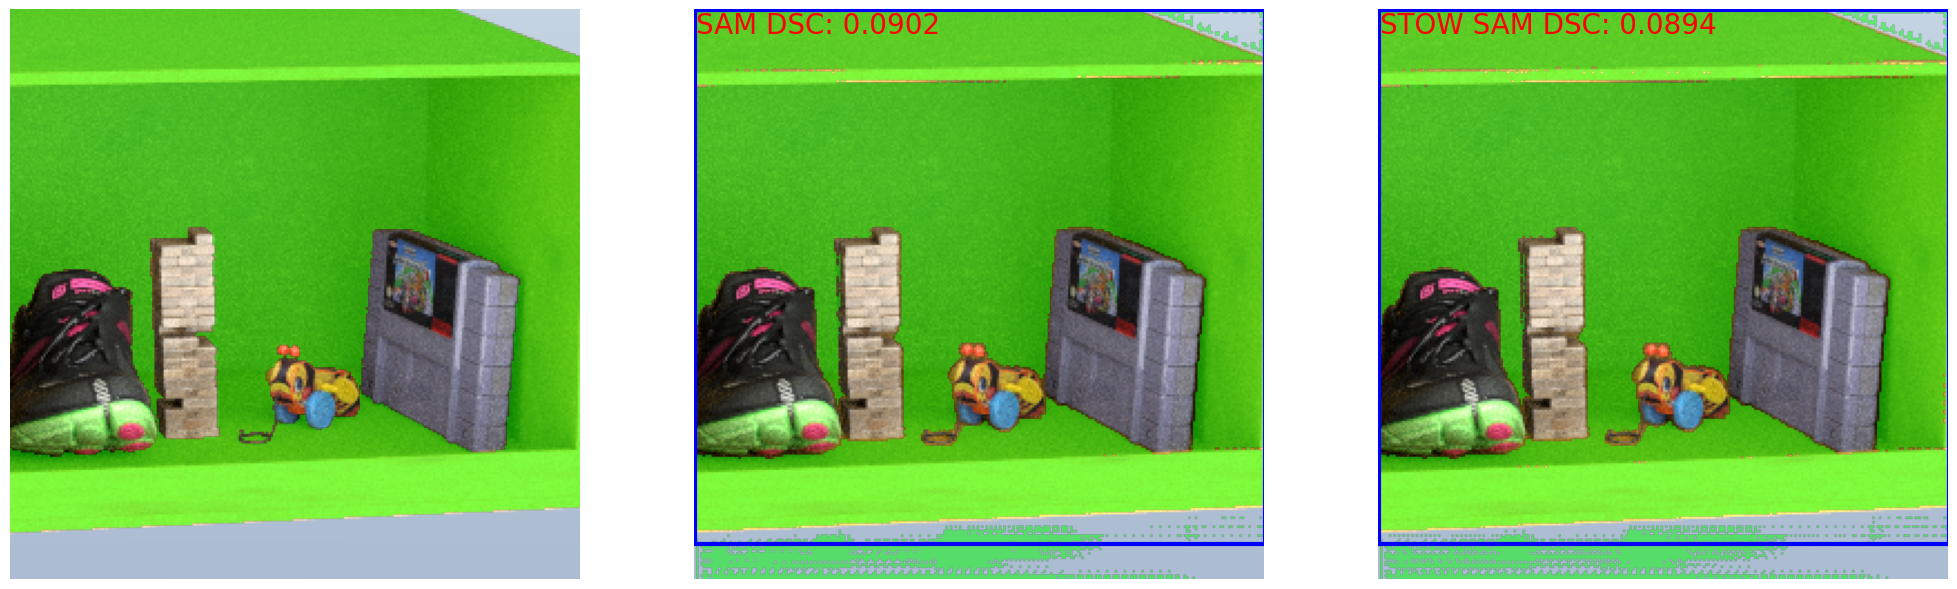

In [31]:
#%% visualize the segmentation results of the middle slice
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([0/255, 255/255, 0/255, 0.5])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=3))    

_, axs = plt.subplots(1, 3, figsize=(25, 25))
axs[0].imshow(image_data)
show_mask(gt_data == 0, axs[0])
# show_box(box_np[img_id], axs[0])
# axs[0].set_title('Mask with Tuned Model', fontsize=20)
axs[0].axis('off')

axs[1].imshow(image_data)
show_mask(ori_sam_seg, axs[1])
show_box(bbox_raw, axs[1])
# add text to image to show dice score
axs[1].text(0.5, 0.5, 'SAM DSC: {:.4f}'.format(ori_sam_dsc), fontsize=20, horizontalalignment='left', verticalalignment='top', color='red')
# axs[1].set_title('Mask with Untuned Model', fontsize=20)
axs[1].axis('off')

axs[2].imshow(image_data)
show_mask(stow_sam_seg, axs[2])
show_box(bbox_raw, axs[2])
# add text to image to show dice score
axs[2].text(0.5, 0.5, 'STOW SAM DSC: {:.4f}'.format(stow_sam_dsc), fontsize=20, horizontalalignment='left', verticalalignment='top', color='red')
# axs[2].set_title('Ground Truth', fontsize=20)
axs[2].axis('off')
plt.show()  
plt.subplots_adjust(wspace=0.01, hspace=0)
# save plot
# plt.savefig(join(model_save_path, test_npzs[npz_idx].split('.npz')[0] + str(img_id).zfill(3) + '.png'), bbox_inches='tight', dpi=300)
plt.close()